In [1]:
 from pyspark import SparkConf
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import matplotlib.pyplot as plt  
%matplotlib inline
from pyspark.ml.regression import LinearRegression
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
from pyspark.sql.functions import col

In [2]:
# read the file and see columns
df = sqlContext.read.load('file:///home/cloudera/Downloads/winequality-red.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')
df.columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [3]:
df = df.select(col("fixed acidity").alias("fixed_acidity"),col("volatile acidity").alias("volatile_acidity"), col("citric acid").alias("citric_acid"), 
col("residual sugar").alias("residual_sugar"),'chlorides',col("free sulfur dioxide").alias("free_sulfur_dioxide"),
col("total sulfur dioxide").alias("total_sulfur_dioxide"),'density','pH','sulphates','alcohol','quality')
df.columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [4]:
# drop missing values
df = df.na.drop()

In [5]:
# lets see the Schema of the data
df.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [6]:
# count numbers of rows and columns in the DataFrame
df.count(), len(df.columns)

(1599, 12)

In [7]:
# convert value quality from int to double
from pyspark.sql.types import DoubleType
df = df.withColumn("quality", df["quality"].cast(DoubleType()))

In [8]:
# lets see correlations of the parameters
df.toPandas().corr()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile_acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric_acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual_sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free_sulfur_dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total_sulfur_dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [9]:
# lets determine features we are going in the model to predict quality
featureColumns=['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
 'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']

In [10]:
# constructing vector of features
vectorAssembler = VectorAssembler(inputCols = featureColumns, outputCol = 'features')
df1 = vectorAssembler.transform(df)
workingDF=df1.select('features','quality')

In [11]:
# devide data into test data and training data
(trainingData, testData) = workingDF.randomSplit([0.8, 0.2], seed=13234)

In [12]:
# count data
trainingData.count(), testData.count()

(1281, 318)

In [13]:
# description of the training dataset
trainingData.describe().show()

+-------+------------------+
|summary|           quality|
+-------+------------------+
|  count|              1281|
|   mean| 5.629976580796253|
| stddev|0.8036094838764112|
|    min|               3.0|
|    max|               8.0|
+-------+------------------+



In [14]:
# descption of the test data
testData.describe().show()

+-------+------------------+
|summary|           quality|
+-------+------------------+
|  count|               318|
|   mean| 5.660377358490566|
| stddev|0.8241633836921339|
|    min|               3.0|
|    max|               8.0|
+-------+------------------+



In [16]:
# creating the model and training it on the training data set 
lr = LinearRegression(featuresCol = 'features', labelCol='quality', maxIter=10, regParam=0.2, elasticNetParam=0.8)
lr_model = lr.fit(trainingData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: (11,[1,10],[-0.67924211377,0.179779535817])
Intercept: 4.115422848824982


In [18]:
# lets see how well our model has fit training data (compare prediction and quality)
lr_training = lr_model.transform(trainingData)
lr_training.select("prediction","quality","features").show(5)

+------------------+-------+--------------------+
|        prediction|quality|            features|
+------------------+-------+--------------------+
|6.1173288688661565|    4.0|[4.6,0.52,0.15,2....|
|  6.02703359260117|    6.0|[4.7,0.6,0.17,2.3...|
| 6.347054662478385|    8.0|[5.0,0.42,0.24,2....|
| 5.310281018857156|    4.0|[5.0,1.02,0.04,1....|
|5.4764757123986705|    5.0|[5.0,1.04,0.24,1....|
+------------------+-------+--------------------+
only showing top 5 rows



In [19]:
# evaluate squared error on training data
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="quality",metricName="r2")
print("R Squared (R2) on training data = %g" % 
lr_evaluator.evaluate(lr_training))

R Squared (R2) on training data = 0.255531


In [20]:
# lets apply our trained model on the test data
lr_predictions = lr_model.transform(testData)
lr_predictions.select("prediction","quality","features").show(5)

+------------------+-------+--------------------+
|        prediction|quality|            features|
+------------------+-------+--------------------+
| 6.347054662478385|    7.0|[4.9,0.42,0.0,2.1...|
| 6.401394031579988|    6.0|[5.2,0.34,0.0,1.8...|
| 5.975499041687505|    7.0|[5.3,0.57,0.01,1....|
|5.8853896494469025|    7.0|[5.4,0.835,0.08,1...|
|5.5588295230718945|    5.0|[5.6,0.31,0.37,1....|
+------------------+-------+--------------------+
only showing top 5 rows



In [21]:
# lets see the difference
lr_predictions.select('prediction', 'quality').show(10)

+------------------+-------+
|        prediction|quality|
+------------------+-------+
| 6.347054662478385|    7.0|
| 6.401394031579988|    6.0|
| 5.975499041687505|    7.0|
|5.8853896494469025|    7.0|
|5.5588295230718945|    5.0|
| 5.547238482271375|    5.0|
| 5.463296378479798|    6.0|
|5.8110785252887265|    6.0|
| 5.510471558394935|    5.0|
| 5.510471558394935|    5.0|
+------------------+-------+
only showing top 10 rows



In [22]:
# evaluate squared error on the test data
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="quality",metricName="r2")
print("R Squared (R2) on test data = %g" % 
lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.228466


In [23]:
# we can see that a lot coefficients are zero 
# probably because in the correlation table above some values were really low (<<1)
lr_model.coefficients, lr_model.intercept
# so we can see the dependence of quality only on 2 parameters:fixed acidity and sulphates:
# The model is : q = -0.6792*fa + 0.1798*sul + 4.584826, where fa = fixed acidity and sul=sulphates

(SparseVector(11, {1: -0.6792, 10: 0.1798}), 4.115422848824982)

In [24]:
# let analyse the graphic and confirm that there is no clear linear dependance
pdd=df.select('density','quality')
pddf_pred = pdd.toPandas()
pddf_pred.head()

,density,quality
0,0.9978,5.0
1,0.9968,5.0
2,0.9970,5.0
3,0.9980,6.0
4,0.9978,5.0


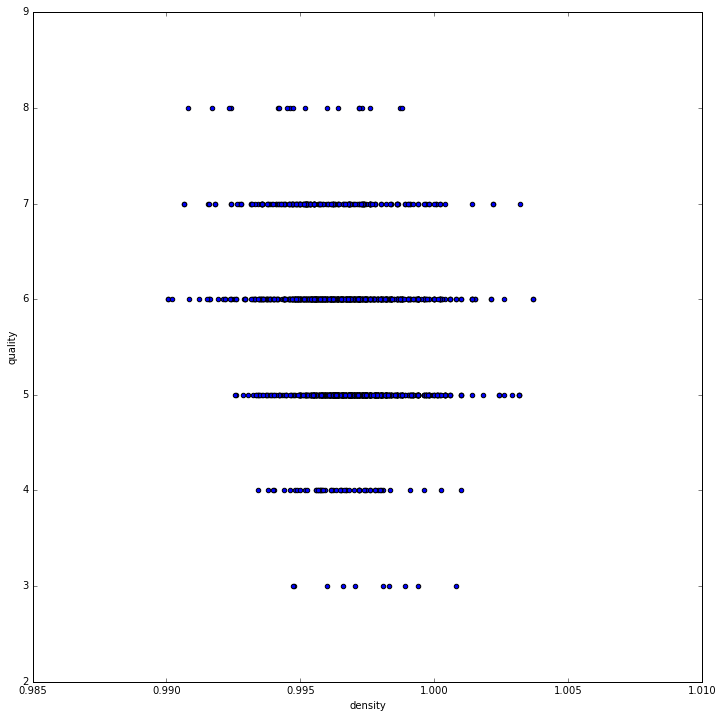

In [25]:
# we can see that quality doesn't depend linearly on density (for example)
d = plt.figure(figsize=(12,12))
plt.scatter(pddf_pred.density, pddf_pred.quality)
plt.xlabel('density')
plt.ylabel('quality')
plt.show()

In [26]:
pdd1=df.select('fixed_acidity','sulphates','quality')
pddf_pred1 = pdd1.toPandas()
pddf_pred1.head()

,fixed_acidity,sulphates,quality
0,7.4,0.56,5.0
1,7.8,0.68,5.0
2,7.8,0.65,5.0
3,11.2,0.58,6.0
4,7.4,0.56,5.0
